
# Creating and joining GeoDataFrames
> You'll work with GeoJSON to create polygonal plots, learn about projections and coordinate reference systems, and get practice spatially joining data in this chapter. This is the Summary of lecture "Visualizing Geospatial Data in Python", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Visualization]
- image: images/urban_art.png

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)

## GeoJSON and plotting with geopandas
- Geopandas dependencies
    - Fiona
        - provides an python API for OGR
    - GDAL (Geospartial Data Abstraction Library) /OGR (Open GIS simple features Reference)
        - GDAL for translating raster data
        - OGR for translating vector data

### Colormaps
When you want to differentiate regions, but not imply any type of relationship between the regions, a qualitative colormap is the best choice. In this exercise you'll compare a qualitative colormap to a sequential (quantitative) colormap using the school districts GeoDataFrame. 

In [2]:
school_districts = gpd.read_file('./dataset/school_districts.geojson')

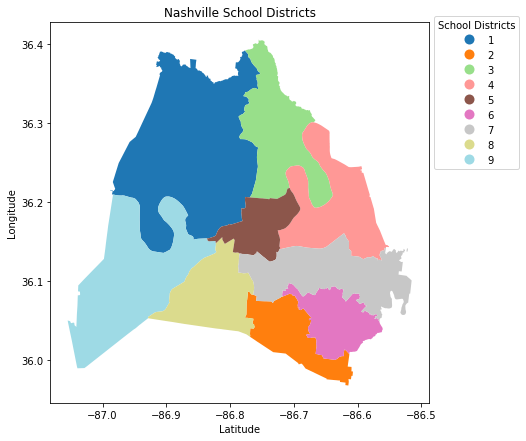

In [3]:
# set legend style
lgnd_kwds = {'title': 'School Districts', 'loc': 'upper left',
             'bbox_to_anchor': (1, 1.03), 'ncol':1}

# Plot the school districts using the tab20 colormap (qualitative)
school_districts.plot(column='district', cmap='tab20', legend=True, legend_kwds=lgnd_kwds, figsize=(7,7));
plt.xlabel('Latitude');
plt.ylabel('Longitude');
plt.title('Nashville School Districts');

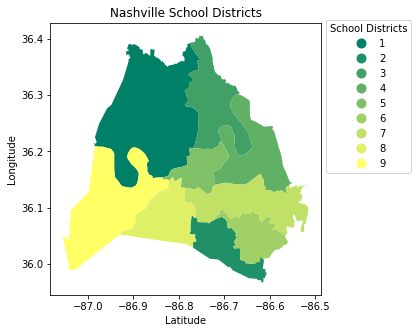

In [4]:
# Plot the school districts using the summer colormap (sequential)
school_districts.plot(column='district', cmap='summer', legend=True, legend_kwds=lgnd_kwds);
plt.xlabel('Latitude');
plt.ylabel('Longitude');
plt.title('Nashville School Districts');

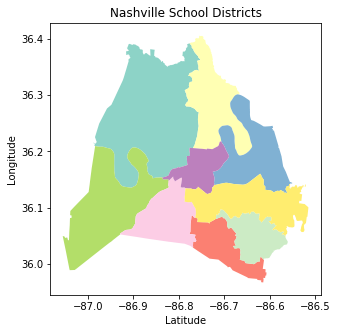

In [5]:
# Plot the school districts using the Set3 colormap without the column argument
school_districts.plot(cmap='Set3', legend=True, legend_kwds=lgnd_kwds);
plt.xlabel('Latitude');
plt.ylabel('Longitude');
plt.title('Nashville School Districts');

### Map Nashville neighborhoods
This time you'll read a GeoJSON file in to a GeoDataFrame to take a quick peek at where Nashville neighborhoods are.

                   name                                           geometry
0  Historic Buena Vista  MULTIPOLYGON (((-86.79511 36.17576, -86.79403 ...
1        Charlotte Park  MULTIPOLYGON (((-86.87460 36.15758, -86.87317 ...
2              Hillwood  MULTIPOLYGON (((-86.87614 36.13554, -86.87583 ...
3            West Meade  MULTIPOLYGON (((-86.90384 36.12554, -86.90328 ...
4          White Bridge  MULTIPOLYGON (((-86.86321 36.12886, -86.86321 ...


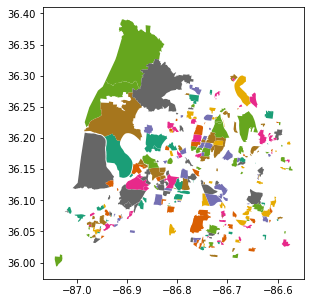

In [6]:
# Read in the neighborhoods geojson file
neighborhoods = gpd.read_file('./dataset/neighborhoods.geojson')

# Print the first few rows of neighborhoods
print(neighborhoods.head())

# Plot the neighborhoods, color according to name and use the Dark2 colormap
neighborhoods.plot(column='name', cmap='Dark2');

## Projections and coordinate reference systems
- Coordinate Reference Systems
    - EPSG:4326
        - used by Google Earth
        - units are decimal degrees
    - EPSG:3857
        - used by Google Maps, Bing Maps, Open Street Maps
        - units are meters

### Changing coordinate reference systems
In this exercise you will learn how to find a GeoDataFrame's coordinate reference system and how to change it.

In [7]:
# Print the first row of school districts GeoDataFrame and the crs
print(school_districts.head(1))
print(school_districts.crs)

# Convert the crs to epsg:3857
school_districts.geometry = school_districts.geometry.to_crs(epsg=3857)

# Print the first row of school districts GeoDataFrame and the crs
print(school_districts.head(1))
print(school_districts.crs)

   first_name       city    zip                           email state  \
0  Dr. Sharon  Nashville  37218  gentryfordistrict1@comcast.net    TN   

  last_name          address position term_expir district         phone  \
0    Gentry  6108 Beals Lane   Member       2016        1  615-268-5269   

                                            geometry  
0  MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ...  
epsg:4326
   first_name       city    zip                           email state  \
0  Dr. Sharon  Nashville  37218  gentryfordistrict1@comcast.net    TN   

  last_name          address position term_expir district         phone  \
0    Gentry  6108 Beals Lane   Member       2016        1  615-268-5269   

                                            geometry  
0  MULTIPOLYGON (((-9659344.056 4353528.767, -965...  
epsg:3857


You can change the coordinate reference system of a GeoDataFrame by changing the crs property of the GeoDataFrame. Notice that the units for geometry change when you change the CRS. You always need to ensure two GeoDataFrames share the same crs before you spatially join them.

### Construct a GeoDataFrame from a DataFrame
In this exercise, you will construct a geopandas GeoDataFrame from the Nashville Public Art DataFrame. You will need to import the `Point` constructor from the `shapely.geometry` module to create a geometry column in art before you can create a GeoDataFrame from `art`. This will get you ready to spatially join the art data and the neighborhoods data in order to discover which neighborhood has the most art.

In [8]:
art = gpd.read_file('./dataset/public_art.csv')

In [9]:
from shapely.geometry import Point

# Print tthe first few rows of the art DataFrame
print(art.head())

# Create a geometry column from lng & lat
art['geometry'] = art.apply(lambda x: Point(float(x.Longitude), float(x.Latitude)), axis=1)

# Create a GeoDataFrame from art and verify the type
art_geo = gpd.GeoDataFrame(art, crs=neighborhoods.crs, geometry=art.geometry)
print(type(art_geo))

                             Title                                 Last Name  \
0          [Cross Country Runners]                                     Frost   
1  [Fourth and Commerce Sculpture]                                    Walker   
2              12th & Porter Mural                                   Kennedy   
3                A Splash of Color  Stevenson and Stanley and ROFF (Harroff)   
4             A Story of Nashville                                    Ridley   

                  First Name                           Location  \
0                      Miley     4001 Harding Rd., Nashville TN   
1                        Lin  333 Commerce Street, Nashville TN   
2                        Kim                  114 12th Avenue N   
3  Doug and Ronnica and Lynn                   616 17th Ave. N.   
4                       Greg    615 Church Street, Nashville TN   

                                              Medium       Type  \
0                                             Bro

Now that the public art data is in a GeoDataFrame we can join it to the neighborhoods with a special kind of join called a spatial join. Let's go learn about how that's done!

## Spatial joins


### Spatial join practice
Is there a difference between art (point data) that intersects with neighborhoods (polygon data) and art (point data) within neighborhoods (polygon data)?

In [10]:
# Spatially join art_geo and neighborhoods
art_intersect_neighborhoods = gpd.sjoin(art_geo, neighborhoods, op='intersects')

# Print the shape property of art_intersect_neighborhoods
print(art_intersect_neighborhoods.shape)

(40, 13)


In [11]:
# Create art_within_neighborhoods by spatially joining art_geo and neighborhoods
art_within_neighborhoods = gpd.sjoin(art_geo, neighborhoods, op = 'within')

# Print the shape property of art_within_neighborhoods
print(art_within_neighborhoods.shape)

(40, 13)


In [12]:
# Spatially join art_geo and neighborhoods and using the contains op
art_containing_neighborhoods = gpd.sjoin(art_geo, neighborhoods, op = 'contains')

# Print the shape property of art_containing_neighborhoods
print(art_containing_neighborhoods.shape)

(0, 13)


There are no neighborhood polygons contained within an artworks point location.

### Finding the neighborhood with the most public art
Now that you have created `art_geo`, a GeoDataFrame, from the `art` DataFrame, you can join it spatially to the `neighborhoods` data to see what art is in each neighborhood.

In [13]:
# Spartially join neighborhoods with art_geo
neighborhood_art = gpd.sjoin(art_geo, neighborhoods, op='within')

# Print the first few rows
print(neighborhood_art.head())

                                Title Last Name First Name  \
1     [Fourth and Commerce Sculpture]    Walker        Lin   
4                A Story of Nashville    Ridley       Greg   
21                        Chet Atkins     Faxon    Russell   
22  Children's Chairs For The Seasons    McGraw     Deloss   
34                    Foliated Scroll   Bloomer       Kent   

                                             Location  \
1                   333 Commerce Street, Nashville TN   
4                     615 Church Street, Nashville TN   
21  Corner of Fifth Avenue North and Union Street,...   
22                    615 Church Street, Nashville TN   
34                    615 Church Street, Nashville TN   

                                         Medium       Type  \
1                                                Sculpture   
4                      Hammered copper repousse     Frieze   
21  Bronze stool and guitar on a granite plynth  Sculpture   
22                 Mixed Media - woo

Now that you have successfully joined art and neighborhoods you can see the title and other information about the artwork along with the name of the neighborhood where it is located. Next you'll do the work to see what art is in which neighborhood!

### Aggregating points within polygons
Now that you have spatially joined `art` and `neighborhoods`, you can group, aggregate, and sort the data to find which neighborhood has the most public art. You can count artwork titles to see how many artworks are in each neighborhood.

In [14]:
# Get name and title from neighborhood_art and group by name
neighborhood_art_grouped = neighborhood_art[['name', 'Title']].groupby('name')

# Aggregate the grouped data and count the artworks within each polygon
print(neighborhood_art_grouped.agg('count').sort_values(by='Title', ascending=False))

                          Title
name                           
Urban Residents              22
Lockeland Springs             3
Edgehill (ONE)                2
Germantown                    2
Hillsboro-West End            2
Inglewood                     2
Sunnyside                     2
Chestnut Hill (TAG)           1
Historic Edgefield            1
McFerrin Park                 1
Renraw                        1
Wedgewood Houston (SNAP)      1


It looks like most of the public art is in the Urban Residents neighborhood. Next you'll subset neighborhood art and neighborhoods to get only the Urban Residents art and neighborhood.

### Plotting the Urban Residents neighborhood and art
Now you know that most art is in the Urban Residents neighborhood. In this exercise, you'll create a plot of art in that neighborhood. First you will subset just the `urban_art` from `neighborhood_art` and you'll subset the `urban_polygon` from `neighborhoods`. Then you will create a plot of the polygon as `ax` before adding a plot of the art.

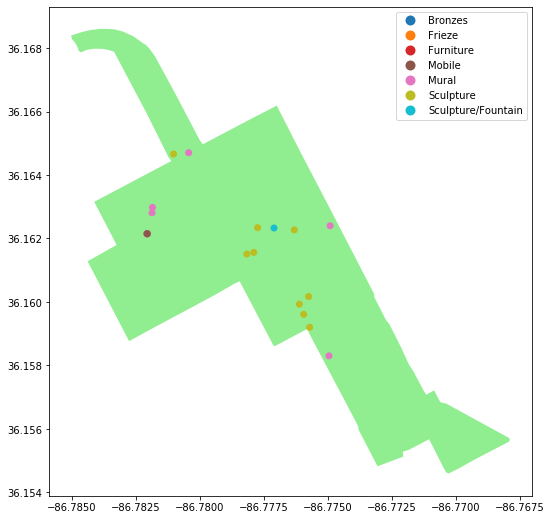

In [15]:
# Create urban_art from neighborhood_art where the neighborhood name is Urban Residents
urban_art = neighborhood_art.loc[neighborhood_art.name == 'Urban Residents']

# Get just the Urban Residents neighborhood polygon and save it as urban_polygon
urban_polygon = neighborhoods.loc[neighborhoods.name == "Urban Residents"]

# Plot the urban_polygon as ax 
ax = urban_polygon.plot(color = 'lightgreen', figsize=(9, 9))

# Add a plot of the urban_art and show it
urban_art.plot( ax = ax, column = 'Type', legend = True);